In [1]:
from scipy.integrate import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter, report_fit

In [2]:
df = pd.read_csv('covid19casesdemographics.csv')

In [3]:
age_df = df[df['demographic_category']== 'Age Group']

In [4]:
age_df['demographic_value'].unique()

array(['0-17', '18-49', '50-64', '65+', 'Missing', 'Total', 'missing'],
      dtype=object)

In [5]:
age_df = age_df[age_df.demographic_value.isin(['0-17', '18-49', '50-64', '65+'])]

In [6]:
#California population obtained from google
Population = 39538223
Days = len(age_df['report_date'].unique())

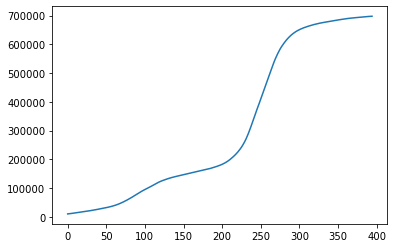

In [7]:
#obtain Infected data

ages = ['0-17', '18-49', '50-64', '65+']

Inf = dict()
for i in ages:
    age_group = age_df[age_df['demographic_value'] == i]
    Ii = []
    
    #first day
    Ii.append(age_group['total_cases'].iloc[0])
    
    #for first day 1-7, do average of its neighbors
    for k in range(1, 7):
        Ii.append(np.mean(age_group['total_cases'].iloc[k-1:k+1]))
    
    #moving average of windows of t = 15
    for k in range(7, len(age_group['total_cases'])-7):
        Ii.append(np.mean(age_group['total_cases'].iloc[k-7:k+7]))
    
    #for last -7 to -1 days do average of its neighbors
    for k in range(len(age_group['total_cases'])-7, len(age_group['total_cases'])-1):
        Ii.append(np.mean(age_group['total_cases'].iloc[k-1:k+1]))
    #for last day, just append the value
    Ii.append(age_group['total_cases'].iloc[Days-1])
    Inf[i] = Ii
plt.plot(range(len(Inf['50-64'])),Inf['50-64'])

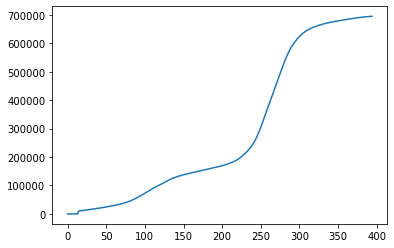

In [8]:
#Obtain Recovered+Death Data
Recovery_days = 14

R_a = dict()
for i in ages:
    Ri = []
    for k in range(0, Recovery_days):
        Ri.append(0)
    
    for k in range(Recovery_days, Days):
        Ri.append(Inf[i][k-Recovery_days])
    R_a[i] = Ri
#plt.plot(range(len(R_a['0-17'])),R_a['0-17'])
#plt.plot(range(len(R_a['18-49'])),R_a['18-49'])
plt.plot(range(len(R_a['50-64'])),R_a['50-64'])
#plt.plot(range(len(R_a['65+'])),R_a['65+'])

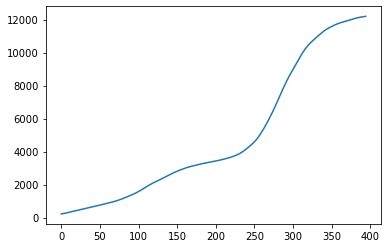

In [9]:
#obtain Death data

ages = ['0-17', '18-49', '50-64', '65+']

D = dict()
for i in ages:
    age_group = age_df[age_df['demographic_value'] == i]
    Di = []
    
    #first day
    Di.append(age_group['deaths'].iloc[0])
    
    #for first day 1-7, do average of its neighbors
    for k in range(1, 7):
        Di.append(np.mean(age_group['deaths'].iloc[k-1:k+1]))
    
    #moving average of windows of t = 15
    for k in range(7, len(age_group['deaths'])-7):
        Di.append(np.mean(age_group['deaths'].iloc[k-7:k+7]))
    
    #for last -7 to -1 days do average of its neighbors
    for k in range(len(age_group['deaths'])-7, len(age_group['deaths'])-1):
        Di.append(np.mean(age_group['deaths'].iloc[k-1:k+1]))
    #for last day, just append the value
    Di.append(age_group['deaths'].iloc[Days-1])
    D[i] = Di
#plt.plot(range(len(D['0-17'])),D['0-17'])
#plt.plot(range(len(D['18-49'])),D['18-49'])
plt.plot(range(len(D['50-64'])),D['50-64'])
#plt.plot(range(len(D['65+'])),D['65+'])

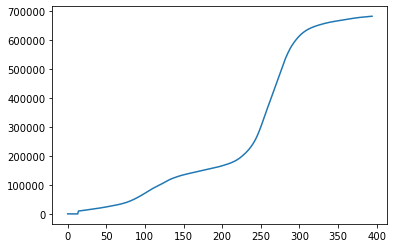

In [10]:
#Obtain Recovered Data
R = dict()
for i in ages:
    Ri = []
    for k in range(0, Days):
        Ri.append(R_a[i][k]-D[i][k])
    R[i] = Ri
#plt.plot(range(len(R['0-17'])),R['0-17'])
#plt.plot(range(len(R['18-49'])),R['18-49'])
plt.plot(range(len(R['50-64'])),R['50-64'])
#plt.plot(range(len(R['65+'])),R['65+'])

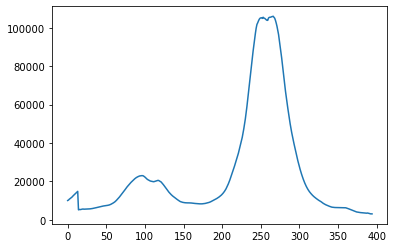

In [11]:
#Obtain infectious Data
I = dict()
for i in ages:
    Ii = []
    for k in range(0, Days):
        Ii.append(Inf[i][k]-R_a[i][k])
    I[i] = Ii
#plt.plot(range(len(I['0-17'])),I['0-17'])
#plt.plot(range(len(I['18-49'])),I['18-49'])
plt.plot(range(len(I['50-64'])),I['50-64'])
#plt.plot(range(len(I['65+'])),I['65+'])

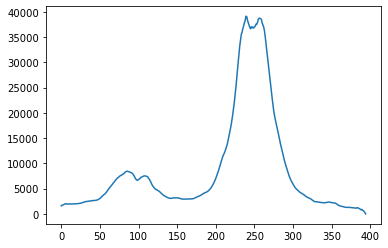

In [12]:
#Obtain Exposed Data
incubation_days = 5

E = dict()
for i in ages:
    Ei = []
    for k in range(0, Days-incubation_days):
        Ei.append(Inf[i][k+incubation_days]-Inf[i][k])
    
    for k in range(Days-incubation_days, Days):
        Ei.append(Inf[i][Days-1]-Inf[i][k])
    E[i] = Ei
#plt.plot(range(len(E['0-17'])),E['0-17'])
#plt.plot(range(len(E['18-49'])),E['18-49'])
plt.plot(range(len(E['50-64'])),E['50-64'])
#plt.plot(range(len(E['65+'])),E['65+'])

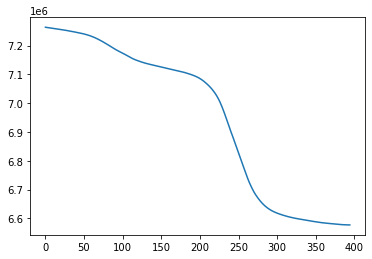

In [13]:
#obtain Susceptible data
percentages = age_df['percent_of_ca_population'].unique()
age_pop = dict(zip(ages, percentages))

S = dict()
for age in ages:
    Si = []
    for i, j, k, m in zip(E[age], I[age], R[age], D[age]):
        Si.append(age_pop[age]*Population/100-i-j-k-m)
    S[age] = Si
plt.plot(range(len(S['50-64'])),S['50-64'])

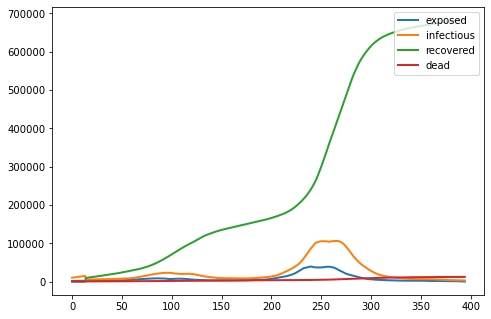

In [20]:
#plot SEIR from data
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(range(len(S['50-64'])),S['50-64'],lw=2,label='suceptible')
ax.plot(range(len(E['50-64'])),E['50-64'],lw=2,label='exposed')
ax.plot(range(len(I['50-64'])),I['50-64'],lw=2,label='infectious')
ax.plot(range(len(R['50-64'])),R['50-64'],lw=2,label='recovered')
ax.plot(range(len(D['50-64'])),D['50-64'],lw=2,label='dead')
#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')

In [18]:
ages = ['0-17', '18-49', '50-64', '65+']
labels = ['1','2','3','4']
for i in range(0,4):
    vars()['S_'+labels[i]] = S[ages[i]]
    vars()['E_'+labels[i]] = E[ages[i]]
    vars()['I_'+labels[i]] = I[ages[i]]
    vars()['R_'+labels[i]] = R[ages[i]]
    vars()['D_'+labels[i]] = D[ages[i]]
    
N = []
for k in range(0, Days):
    Ni = 0
    for i in ages:
        Ni = Ni + S[i][k]+E[i][k]+I[i][k]+R[i][k]
    N.append(Ni)
#plt.plot(range(len(N)),N)
    

In [12]:
#For group 1
C_1 = []
d_1 = []
for t in range(1, Days):
    c = [[-S_1[t]*I_1[t]/N[t], -S_1[t]*I_2[t]/N[t], -S_1[t]*I_3[t], -S_1[t]*I_4[t], 0],
        [S_1[t]*I_1[t], S_1[t]*I_2[t], S_1[t]*I_3[t], S_1[t]*I_4[t], -I_1[t]],
        [0,0,0,0, I_1[t]]]
    C_1.append(c[0])
    C_1.append(c[1])
    C_1.append(c[2])
    
    partial_d = [[S_1[t]-S_1[t-1]], [I_1[t]-I_1[t-1]], [R_1[t]-R_1[t-1]]]
    d_1.append(partial_d[0])
    d_1.append(partial_d[1])
    d_1.append(partial_d[2])


C_1 = np.array(C_1)
d_1 = np.array(d_1)

A_1 = np.linalg.lstsq(C_1, d_1, rcond=None)[0]


#For group 2
C_2 = []
d_2 = []
for t in range(1, Days):
    c = [[-S_2[t]*I_1[t], -S_2[t]*I_2[t], -S_2[t]*I_3[t], -S_2[t]*I_4[t], 0],
        [S_2[t]*I_1[t], S_2[t]*I_2[t], S_2[t]*I_3[t], S_2[t]*I_4[t], -I_2[t]],
        [0,0,0,0, I_2[t]]]
    C_2.append(c[0])
    C_2.append(c[1])
    C_2.append(c[2])
    
    partial_d = [[S_2[t]-S_2[t-1]], [I_2[t]-I_2[t-1]], [R_2[t]-R_2[t-1]]]
    d_2.append(partial_d[0])
    d_2.append(partial_d[1])
    d_2.append(partial_d[2])


C_2 = np.array(C_2)
d_2 = np.array(d_2)

A_2 = np.linalg.lstsq(C_2, d_2, rcond=None)[0]


#For group 3
C_3 = []
d_3 = []
for t in range(1, Days):
    c = [[-S_3[t]*I_1[t], -S_3[t]*I_2[t], -S_3[t]*I_3[t], -S_3[t]*I_4[t], 0],
        [S_3[t]*I_1[t], S_3[t]*I_2[t], S_3[t]*I_3[t], S_3[t]*I_4[t], -I_3[t]],
        [0,0,0,0, I_3[t]]]
    C_3.append(c[0])
    C_3.append(c[1])
    C_3.append(c[2])
    
    partial_d = [[S_3[t]-S_3[t-1]], [I_3[t]-I_3[t-1]], [R_3[t]-R_3[t-1]]]
    d_3.append(partial_d[0])
    d_3.append(partial_d[1])
    d_3.append(partial_d[2])


C_3 = np.array(C_3)
d_3 = np.array(d_3)

A_3 = np.linalg.lstsq(C_3, d_3, rcond=None)[0]


#For group 4
C_4 = []
d_4 = []
for t in range(1, Days):
    c = [[-S_4[t]*I_1[t], -S_4[t]*I_2[t], -S_4[t]*I_3[t], -S_4[t]*I_4[t], 0],
        [S_4[t]*I_1[t], S_4[t]*I_2[t], S_4[t]*I_3[t], S_4[t]*I_4[t], -I_4[t]],
        [0,0,0,0, I_4[t]]]
    C_4.append(c[0])
    C_4.append(c[1])
    C_4.append(c[2])
    
    partial_d = [[S_4[t]-S_4[t-1]], [I_4[t]-I_4[t-1]], [R_4[t]-R_4[t-1]]]
    d_4.append(partial_d[0])
    d_4.append(partial_d[1])
    d_4.append(partial_d[2])


C_4 = np.array(C_4)
d_3 = np.array(d_4)

A_4 = np.linalg.lstsq(C_4, d_4, rcond=None)[0]



In [13]:
#The complete mixing Matrix
A = np.vstack((A_1.T, A_2.T, A_3.T, A_4.T))
